This tutorial notebook shows how to use a neural network architecture for global epistasis regression other than the default choice provided by mavenn

In [14]:
# necessary imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import mavenn
from mavenn.src.utils import get_example_dataset
import tensorflow as tf

Load data using mavenn's helper method. 

In [2]:
X, y = get_example_dataset(name='MPSA')

In [3]:
# X is an array of 9-nt sequences
X[0:10]

array(['AAAGCAAAA', 'AAAGCAAAC', 'AAAGCAAAG', 'AAAGCAAAU', 'AAAGCAACA',
       'AAAGCAACC', 'AAAGCAACG', 'AAAGCAACU', 'AAAGCAAGA', 'AAAGCAAGC'],
      dtype=object)

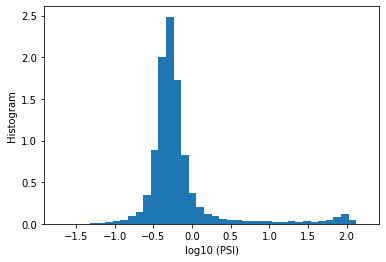

In [4]:
# y = log_10(PSI)
plt.hist(y,bins=40,density=True)
plt.xlabel('log10 (PSI)')
plt.ylabel('Histogram')
plt.show()

In [5]:
# Split data into training and test sets using sklearn
x_train, x_test, y_train, y_test = train_test_split(X, y)

## Define custom model

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Input

# Here we define a custom model based on the tf.keras Model api. 
# For this example we will define an additive model and 
# fit it to mpsa data
number_input_layer_nodes = len(x_train[0])*4
inputTensor = Input((number_input_layer_nodes,))
phi = Dense(1)(inputTensor)
custom_model = Model(inputTensor,phi)

## Fit GE model to data

In [7]:
# the important keyworkd here is 'custom_architecture'
GER = mavenn.Model(regression_type='GE',
                   X=x_train, 
                   y=y_train, 
                   model_type='additive',
                   learning_rate=0.0005,
                   monotonic=True,
                   alphabet_dict='rna',
                   custom_architecture=custom_model)

GER.fit(epochs=100, use_early_stopping=True, early_stopping_patience=20, verbose=1)

One-hot encoding...
Train on 18717 samples, validate on 4680 samples
Epoch 1/100
18717/18717 [==============================] - 1s 28us/step - loss: 0.4273 - mean_absolute_error: 0.4672 - val_loss: 0.2799 - val_mean_absolute_error: 0.3706
Epoch 2/100
18717/18717 [==============================] - 0s 20us/step - loss: 0.2383 - mean_absolute_error: 0.3265 - val_loss: 0.1984 - val_mean_absolute_error: 0.2942
Epoch 3/100
18717/18717 [==============================] - 0s 20us/step - loss: 0.1983 - mean_absolute_error: 0.2898 - val_loss: 0.1829 - val_mean_absolute_error: 0.2865
Epoch 4/100
18717/18717 [==============================] - 0s 20us/step - loss: 0.1918 - mean_absolute_error: 0.2895 - val_loss: 0.1805 - val_mean_absolute_error: 0.2827
Epoch 5/100
18717/18717 [==============================] - 0s 20us/step - loss: 0.1910 - mean_absolute_error: 0.2899 - val_loss: 0.1803 - val_mean_absolute_error: 0.2873
Epoch 6/100
18717/18717 [==============================] - 0s 20us/step - loss: 0

18717/18717 [==============================] - 0s 24us/step - loss: 0.1910 - mean_absolute_error: 0.2917 - val_loss: 0.1805 - val_mean_absolute_error: 0.2888
Epoch 49/100
18717/18717 [==============================] - 0s 21us/step - loss: 0.1910 - mean_absolute_error: 0.2908 - val_loss: 0.1801 - val_mean_absolute_error: 0.2857
Epoch 50/100
18717/18717 [==============================] - 0s 20us/step - loss: 0.1909 - mean_absolute_error: 0.2916 - val_loss: 0.1802 - val_mean_absolute_error: 0.2838
Epoch 51/100
18717/18717 [==============================] - 0s 21us/step - loss: 0.1910 - mean_absolute_error: 0.2903 - val_loss: 0.1803 - val_mean_absolute_error: 0.2881
Epoch 52/100
18717/18717 [==============================] - 0s 20us/step - loss: 0.1909 - mean_absolute_error: 0.2919 - val_loss: 0.1800 - val_mean_absolute_error: 0.2821
Epoch 53/100
18717/18717 [==============================] - 0s 21us/step - loss: 0.1910 - mean_absolute_error: 0.2900 - val_loss: 0.1802 - val_mean_absolute_e

## Plot results

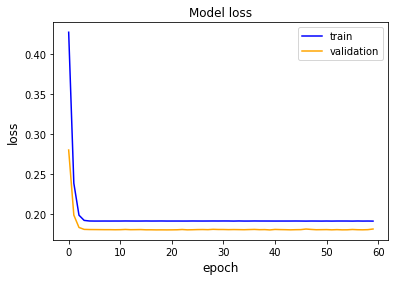

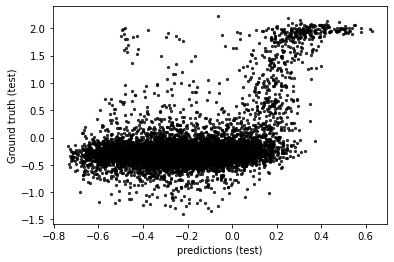

In [8]:
# since this is a linear model, we do not have global epistasis nonlinearity in this case
loss_history =  GER.model.return_loss()
predictions = GER.model.predict(x_test)

plt.plot(loss_history.history['loss'], color='blue')
plt.plot(loss_history.history['val_loss'], color='orange')
plt.title('Model loss', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['train', 'validation'])
plt.show()

plt.scatter(predictions,y_test,s=5, alpha=0.75, color='black')
plt.ylabel('Ground truth (test)')
plt.xlabel('predictions (test)')
plt.show()


A more complicated architecture is shown below

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.constraints import non_neg as nonneg

# For this example we will define an additive GE model
# with 2 hidden layers in the GE sub-network
number_input_layer_nodes = len(x_train[0])*4
inputTensor = Input((number_input_layer_nodes,))
phi = Dense(1)(inputTensor)
intermediateTensor = Dense(30, activation='sigmoid', kernel_constraint=nonneg())(phi)
intermediateTensor = Dense(10, activation='sigmoid', kernel_constraint=nonneg())(intermediateTensor)
outputTensor = Dense(1, kernel_constraint=nonneg())(intermediateTensor)

custom_model_GE = Model(inputTensor,outputTensor)

In [10]:
# the important keyworkd here is 'custom_architecture'
GER_denser = mavenn.Model(regression_type='GE',
                   X=x_train, 
                   y=y_train, 
                   model_type='additive',
                   learning_rate=0.0005,
                   monotonic=True,
                   alphabet_dict='rna',
                   custom_architecture=custom_model_GE)

GER_denser.fit(epochs=100, use_early_stopping=True, early_stopping_patience=20, verbose=1)

One-hot encoding...
Train on 18717 samples, validate on 4680 samples
Epoch 1/100
18717/18717 [==============================] - 1s 49us/step - loss: 0.5018 - mean_absolute_error: 0.6224 - val_loss: 0.2735 - val_mean_absolute_error: 0.4067
Epoch 2/100
18717/18717 [==============================] - 1s 33us/step - loss: 0.2608 - mean_absolute_error: 0.3529 - val_loss: 0.2311 - val_mean_absolute_error: 0.3015
Epoch 3/100
18717/18717 [==============================] - 1s 33us/step - loss: 0.2448 - mean_absolute_error: 0.2929 - val_loss: 0.2269 - val_mean_absolute_error: 0.2744
Epoch 4/100
18717/18717 [==============================] - 1s 33us/step - loss: 0.2436 - mean_absolute_error: 0.2801 - val_loss: 0.2267 - val_mean_absolute_error: 0.2742
Epoch 5/100
18717/18717 [==============================] - 1s 33us/step - loss: 0.2431 - mean_absolute_error: 0.2792 - val_loss: 0.2264 - val_mean_absolute_error: 0.2799
Epoch 6/100
18717/18717 [==============================] - 1s 33us/step - loss: 0

18717/18717 [==============================] - 1s 35us/step - loss: 0.0875 - mean_absolute_error: 0.1809 - val_loss: 0.0835 - val_mean_absolute_error: 0.1776
Epoch 49/100
18717/18717 [==============================] - 1s 36us/step - loss: 0.0874 - mean_absolute_error: 0.1806 - val_loss: 0.0837 - val_mean_absolute_error: 0.1790
Epoch 50/100
18717/18717 [==============================] - 1s 34us/step - loss: 0.0874 - mean_absolute_error: 0.1807 - val_loss: 0.0839 - val_mean_absolute_error: 0.1797
Epoch 51/100
18717/18717 [==============================] - 1s 33us/step - loss: 0.0874 - mean_absolute_error: 0.1807 - val_loss: 0.0832 - val_mean_absolute_error: 0.1776
Epoch 52/100
18717/18717 [==============================] - 1s 33us/step - loss: 0.0874 - mean_absolute_error: 0.1808 - val_loss: 0.0831 - val_mean_absolute_error: 0.1774
Epoch 53/100
18717/18717 [==============================] - 1s 33us/step - loss: 0.0874 - mean_absolute_error: 0.1808 - val_loss: 0.0829 - val_mean_absolute_e

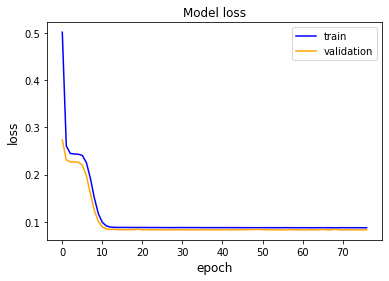

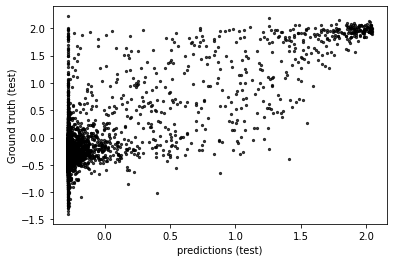

In [11]:
# since this is a linear model, we do not have global epistasis nonlinearity in this case
loss_history =  GER_denser.model.return_loss()
predictions = GER_denser.model.predict(x_test)

plt.plot(loss_history.history['loss'], color='blue')
plt.plot(loss_history.history['val_loss'], color='orange')
plt.title('Model loss', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['train', 'validation'])
plt.show()

plt.scatter(predictions,y_test,s=5, alpha=0.75, color='black')
plt.ylabel('Ground truth (test)')
plt.xlabel('predictions (test)')
plt.show()


In [12]:
denser_model = GER_denser.nn_model()

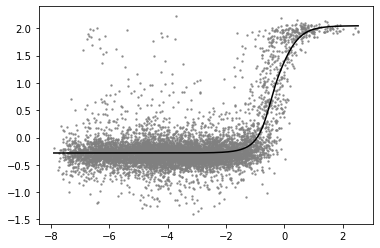

In [13]:
GE_nonlinearity = GER_denser.ge_nonlinearity(x_test)
plt.plot(GE_nonlinearity[1],GE_nonlinearity[0],color='black')
plt.scatter(GE_nonlinearity[2],y_test,color='gray',s=2,alpha=0.75)
plt.show()